# Screwing around to solve for Lorentzian function

In [20]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from fooof import FOOOF, FOOOFGroup

What I call "generalized" Lorentzian function has the form:

$$ P(f) = {1\over(k+f^x)} $$

where $x=2$ is the actual Lorentzian function, or the Cauchy/Lorentzian distribution: https://en.wikipedia.org/wiki/Cauchy_distribution

Of interest:
- homogeneous broadening: https://en.wikipedia.org/wiki/Homogeneous_broadening
- https://en.wikipedia.org/wiki/Category:Power_laws
- Hawkes processes are self-exciting point processes that result in Cauchy distribution shaped power spectrums: https://arxiv.org/pdf/1507.02822.pdf
- Hawkes processes review: https://arxiv.org/pdf/1708.02647.pdf, https://www.esaim-proc.org/articles/proc/pdf/2017/05/proc186004.pdf
- "neural" HP: https://arxiv.org/pdf/1612.09328.pdf
- **HP and other point process modeling of neural populations**: https://www.sciencedirect.com/science/article/pii/S0928425717300086
- french thesis: https://tel.archives-ouvertes.fr/tel-01415622v2/document
- tutorial slides: https://mas2016.sciencesconf.org/data/slidesLoecherbach.pdf

Okay wow that was a deep dive: so I start from trying to approximate the Lorentzian curve, to finding a family of power-law tailed (stable) distributions, one of them being Cauchy (synonymous with Lorentzian). Somehow I randomly stumble onto the fact that Hawkes processes generate power spectrum with Cauchy distributions, which makes sense because it's self-exciting, hence autocorrelated. Finally end with finding a bunch of references that link Hawkes process with neuronal firing. 

HP is a much more natural model than the Poisson process, I think, because of the self-exciting aspect. Well, it seems like below some threshold of (MAYBE) E-I balance, asynchronous dynamics is maintained and produce Poisson like population firing, while after some threshold, Hawkes firing is more reasonable (bursting). The question is, does HP include self-extinguishing behavior, and how do inhibitory mechanisms play a role here, either through refractory period or inhibitory neurons?

Anyway...onto the approximation

In [71]:
def gen_lorentzian(f,x=2,k=0):
    return 1./(k+f**x)

def return_Pknee(f, P, x, k):
    f_knee = k**(1/x)
    P_knee = P[np.argmin(np.abs(f-f_knee))]
    return f_knee, P_knee

def plot_triple(f, P, x, k):
    plt.subplot(1,3,1)
    plt.plot(f,P)
    plt.title('Linear')
    plt.subplot(1,3,2)
    plt.semilogy(f,P)
    plt.title('Log Y')
    plt.subplot(1,3,3)
    plt.loglog(f,P)
    f_k, P_k = return_Pknee(f,P,x,k)
    f_2, P_2 = return_Pknee(f,P,2,k)
    plt.loglog(f_k,P_k, '*k', alpha=0.5)
    plt.loglog(f_2,P_2, 'or', alpha=0.5)
    plt.title('Log Log')
    
    
def plot_triple_log(g, logP, x, k):    
    plt.subplot(1,3,1)
    plt.plot(g, -g*x-np.log10(1+(k/(10.**(g*x)))), '--')
    plt.title('Full')
    plt.subplot(1,3,2)
    plt.plot(g, -g*x)
    plt.title('Power law component (linear)')
    plt.subplot(1,3,3)
    plt.plot(g, -np.log10(1+(k/(10.**(g*x)))))
    plt.title('Weird log component (sigmoid?)')

# Knee dependence on slope
In the following simulations, k is held constant while slope varies, and from the loglog PSD (third). 

100 1.5 [100.00000147   1.5       ]
100 2.0 [99.9999987  2.       ]
100 2.5 [99.99999371  2.49999999]
100 3.0 [100.00000447   3.00000001]
100 3.5 [99.99999098  3.49999998]
100 4.0 [99.99999498  3.99999999]


/Users/rdgao/anaconda3/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:106: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)
/Users/rdgao/anaconda3/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:106: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)
/Users/rdgao/anaconda3/lib/python3.6/site-packages/matplot

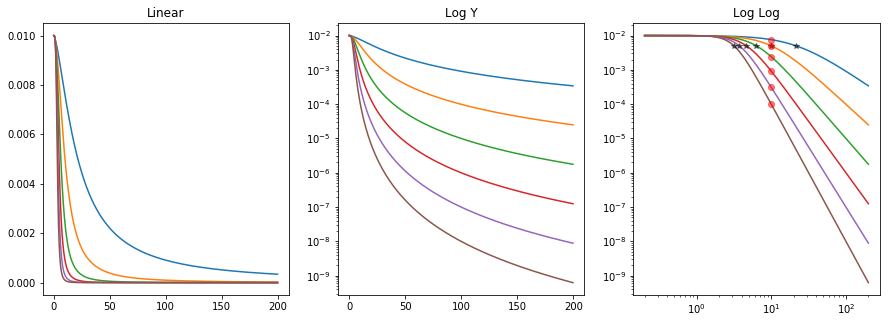

In [72]:
f = np.arange(0,200,.2)
k = 100
ff = FOOOF(max_n_peaks=0, background_mode='knee')
plt.figure(figsize=(15,5))
for x in np.arange(1.5,4.5,0.5):
    P = gen_lorentzian(f, x, k=100)
    ff.fit(f, P, freq_range=[0.5,200])
    print(k,x,ff.background_params_[1:])
    plot_triple(f,P,x,k)

You can see that the "knee location" in terms of frequency is shifting, but fooof fits the parameter perfectly, which is at least a relief. 

So the question is: how to interpret the k parameter given the varying exponent and its shifting position along the frequency axis?

The difficulty in this is the fact that the exponent of 2 is not a product of some constant, as is k, but arises from the Fourier Transform and taking the power (squared magnitude), and I don't know how to reproduce an exponent other than 2 from the time domain?

Black stars indicate knee frequencies computed from taking the x-th root; red circles indicate those computed from taking the square root. Clearly, taking the x-th root finds more reasonable knee frequencies, though I'm not sure if that's still 100% accurate. Curiously, it finds the same power value at each exponent, which makes sense because it basically solves for $f=k^{(1/x)}$, which is when the two terms in the denominator are equal, i.e., $P=0.5P_{max}$. 

Obviously (in hindsight), taking the square root would give the same frequency with the same k, and that's not the right choice, as the knee frequency estimate for higher exponents are way off (brown curve, x=4).

**In conclusion, if the PSD truly has the form of a generalized Lorentzian, then taking the x-th root is more appropriate. However, what is the right choice when it's piece-wise linear where both segments have non-zero slope, i.e., power law multiplied by Lorentzian model? As a first guess, I would say to take the w-th root, where w is the difference between the exponents of the two sections. This would overcome the estimation problem in the above, because you effectively take out the power law component, leaving behind the Lorentzian component. **

# Approximating the log transform
If in linear-linear space power has the form:
$$ P(f) = {1\over(k+f^x)} $$
then taking logP results in:
$$ logP(f) = -log(k+f^x) $$
now substitute 
$$ g = log(f)  => f = 10^g $$
$$ logP(g) = -log(k+10^{gx}) $$
$$ logP(g) = -gx - log(1+{k\over{10^{gx}}}) $$

The last equation describe the curve in the loglog plot *as if* it was linear-linear in the variable logP and g.

When ${k\over{10^{gx}}}$ is small ($<<1$ k is small or g is large), the second term is approximated by $log(1)=0$.

When ${k\over{10^{gx}}}$ is large ($>>1$, k is large or g is small), the second term is approximated by 
$log{k\over{10^{gx}}} = logk - gx$, and the whole thing reduces to $logk$ (plateau).

Refs:
- https://en.wikipedia.org/wiki/List_of_logarithmic_identities
- https://www.dsprelated.com/showthread/comp.dsp/43390-1.php
- https://math.stackexchange.com/questions/698384/approximating-logs-and-antilogs-by-hand

/Users/rdgao/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: RuntimeWarning: divide by zero encountered in log10
  """Entry point for launching an IPython kernel.
/Users/rdgao/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:27: RuntimeWarning: divide by zero encountered in true_divide
/Users/rdgao/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:27: RuntimeWarning: invalid value encountered in subtract
/Users/rdgao/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:33: RuntimeWarning: divide by zero encountered in true_divide
/Users/rdgao/anaconda3/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:106: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  war

Text(0,0.5,'$Log_{10} Power$')

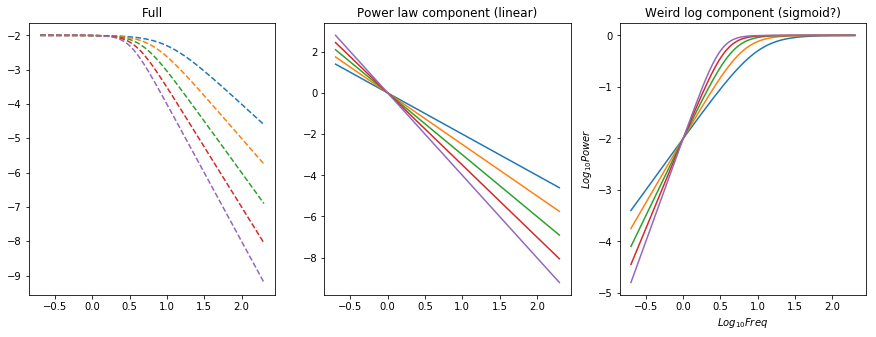

In [78]:
g = np.log10(f)
plt.figure(figsize=(15,5))
for x in np.arange(2,4.5,0.5):
    logP = np.log10(gen_lorentzian(f, x, k))
    plot_triple_log(g, logP, x, k)
plt.xlabel('$Log_{10} Freq$')
plt.ylabel('$Log_{10} Power$')

A few interesting things to note:
- both sets of curves rotate at f=1 (10^0)
- as predicted by the log approximation, when f^x >> k, k has no effect, i.e., flat at higher frequencies in the third plot. In the "equi-power" regime (low frequency), the power law (linear) component and the weird log component have the same slope, and cancel each other out, resulting in the plateau at low frequencies. See the approximation equations above.
- the knee frequency, essentially, is where this transition effect takes over, i.e. $k \approx f^x$.